<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#构建模型" data-toc-modified-id="构建模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>构建模型</a></span></li><li><span><a href="#基础" data-toc-modified-id="基础-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>基础</a></span></li><li><span><a href="#trace-vs-script" data-toc-modified-id="trace-vs-script-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>trace vs script</a></span></li><li><span><a href="#numpy,-python内置和item在trace的时候都会变成常数" data-toc-modified-id="numpy,-python内置和item在trace的时候都会变成常数-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>numpy, python内置和item在trace的时候都会变成常数</a></span></li><li><span><a href="#返回类型不支持dict和string" data-toc-modified-id="返回类型不支持dict和string-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>返回类型不支持dict和string</a></span></li><li><span><a href="#参考" data-toc-modified-id="参考-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>参考</a></span></li></ul></div>

In [2]:
import onnx
from onnx import helper
from onnx import checker

In [3]:
import onnxruntime as ort

In [4]:
import numpy as np

In [5]:
from onnx import TensorProto

In [6]:
import torch

In [7]:
from torch import nn

## 构建模型

In [7]:
class LinearFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 3)
    
    def forward(self, x):
        return self.linear(x)

model = LinearFunc()
input_x = torch.randint(0, 10, size=(3, 2), dtype=torch.float32)
model(input_x)


tensor([[ 0.6296,  1.9170, -0.3229],
        [-0.9982, -0.9552, -1.9080],
        [-3.0003, -2.6534, -4.1017]], grad_fn=<AddmmBackward>)

In [8]:
torch.onnx.export(
    model, 
    (input_x,), 
    "test.onnx", 
    input_names=["input"], 
    output_names=["output"], 
    opset_version=9, 
    verbose=True)

graph(%input : Float(3, 2, strides=[2, 1], requires_grad=0, device=cpu),
      %linear.weight : Float(3, 2, strides=[2, 1], requires_grad=1, device=cpu),
      %linear.bias : Float(3, strides=[1], requires_grad=1, device=cpu)):
  %output : Float(3, 3, strides=[3, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%input, %linear.weight, %linear.bias) # /Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1753:0
  return (%output)



从onnx结构图中可以看到在onnx里面，矩阵乘法对应的是Gemm算子，算子的对应说明在这里：https://onnx.ai/onnx/operators/onnx__Gemm.html#gemm-11

权重和偏置则存储到了graph中的initializer里

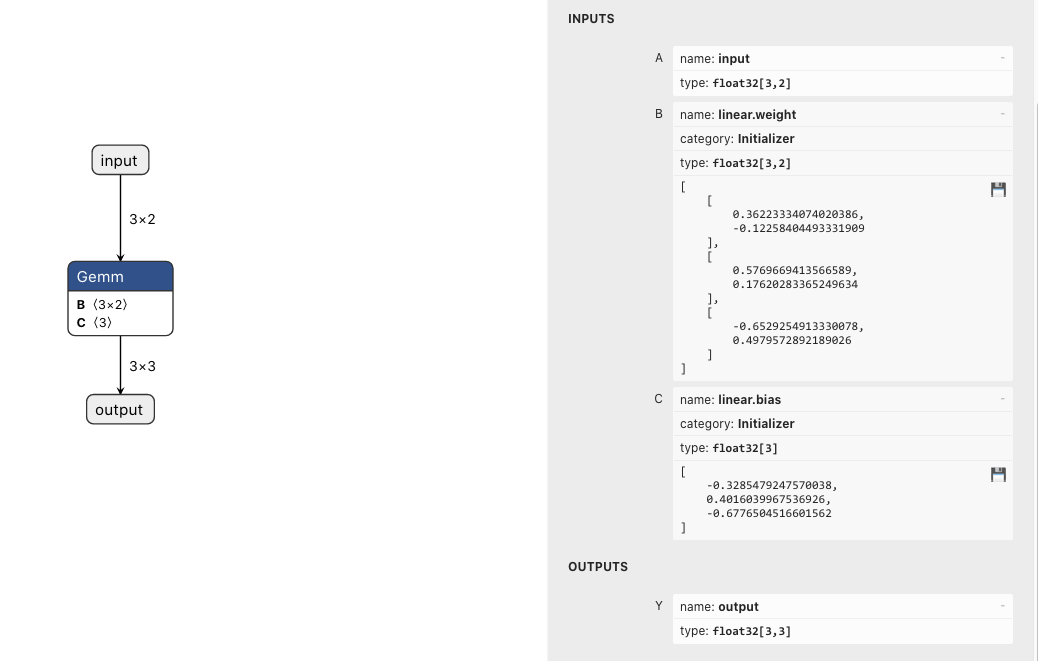

## 基础

In [9]:
onnx_model_file = "test.onnx"
onnx_model = onnx.load(onnx_model_file)

In [10]:
onnx_model

ir_version: 6
producer_name: "pytorch"
producer_version: "1.8"
graph {
  node {
    input: "input"
    input: "linear.weight"
    input: "linear.bias"
    output: "output"
    name: "Gemm_0"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "beta"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "transB"
      i: 1
      type: INT
    }
  }
  name: "torch-jit-export"
  initializer {
    dims: 3
    dims: 2
    data_type: 1
    name: "linear.weight"
    raw_data: "9\300\004?\0324\375\276\237%\'?\375f\262\276\3471\n?\353 \r\277"
  }
  initializer {
    dims: 3
    data_type: 1
    name: "linear.bias"
    raw_data: "b@\354>\346w[\276\360\214x\276"
  }
  input {
    name: "input"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 3
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
  output {
    name: "outp

In [11]:
print(helper.printable_graph(onnx_model.graph))

graph torch-jit-export (
  %input[FLOAT, 3x2]
) initializers (
  %linear.weight[FLOAT, 3x2]
  %linear.bias[FLOAT, 3]
) {
  %output = Gemm[alpha = 1, beta = 1, transB = 1](%input, %linear.weight, %linear.bias)
  return %output
}


In [12]:
checker.check_model(onnx_model)

In [13]:
input_x_np = input_x.numpy()
input_x_np

array([[7., 7.],
       [1., 4.],
       [0., 7.]], dtype=float32)

In [14]:
ort_session = ort.InferenceSession(onnx_model_file)
out = ort_session.run(
    None,  {"input": input_x_np}
)
out

[array([[ 0.62956846,  1.9170061 , -0.32294232],
        [-0.9981658 , -0.9551747 , -1.9080353 ],
        [-3.0003383 , -2.6534183 , -4.10171   ]], dtype=float32)]

## trace vs script

In [14]:
class CondModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        if torch.sum(x) > 10:
            return x
        else:
            return x + 10

cond_model = CondModel()

In [15]:
a = torch.tensor([1, 2, 3])
cond_model(a)

tensor([11, 12, 13])

In [16]:
b = torch.tensor([10, 2, 3])
cond_model(b)

tensor([10,  2,  3])

In [20]:
# using trace
torch.onnx.export(cond_model, (a,), "trace.onnx")

/Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  


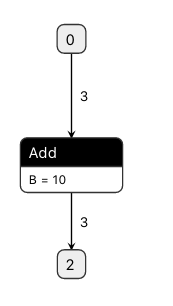

In [25]:
ort_session_trace = ort.InferenceSession("trace.onnx")
out = ort_session_trace.run(
    None,  {"0": a.numpy()}
)
out

[array([11, 12, 13], dtype=int64)]

In [26]:
out = ort_session_trace.run(
    None,  {"0": b.numpy()}
)
out

[array([20, 12, 13], dtype=int64)]

可以看到由于输入的数据之和小于10，所以onnx中只保留了小于10时处理分支，因此即使输入b得到的结果也会加10

In [22]:
# script
torch.onnx.export(torch.jit.script(cond_model), (a,), "script.onnx", example_outputs=torch.tensor([1, 2, 3]))

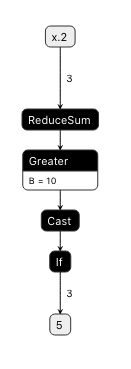

In [28]:
ort_session_trace = ort.InferenceSession("script.onnx")
out = ort_session_trace.run(
    None,  {"x.2": a.numpy()}
)
out

[array([11, 12, 13], dtype=int64)]

In [29]:
out = ort_session_trace.run(
    None,  {"x.2": b.numpy()}
)
out

[array([10,  2,  3], dtype=int64)]

当使用script时保留了不同的条件分支，因此输入b时不做处理

## numpy, python内置和item在trace的时候都会变成常数

In [8]:
class ConstModel(nn.Module):    
    def forward(self, x, y):
        return x.reshape(y.item(), -1)
    
const_model = ConstModel()

In [8]:
a = torch.arange(6)
b = torch.tensor([3])
c = torch.tensor([2])

In [9]:
const_model(a, b), const_model(a, c)

(tensor([[0, 1],
         [2, 3],
         [4, 5]]),
 tensor([[0, 1, 2],
         [3, 4, 5]]))

In [13]:
torch.onnx.export(const_model, (a, b), "const_op.onnx", input_names=["input0", "input1"])

/Users/yangqj/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  This is separate from the ipykernel package so we can avoid doing imports until


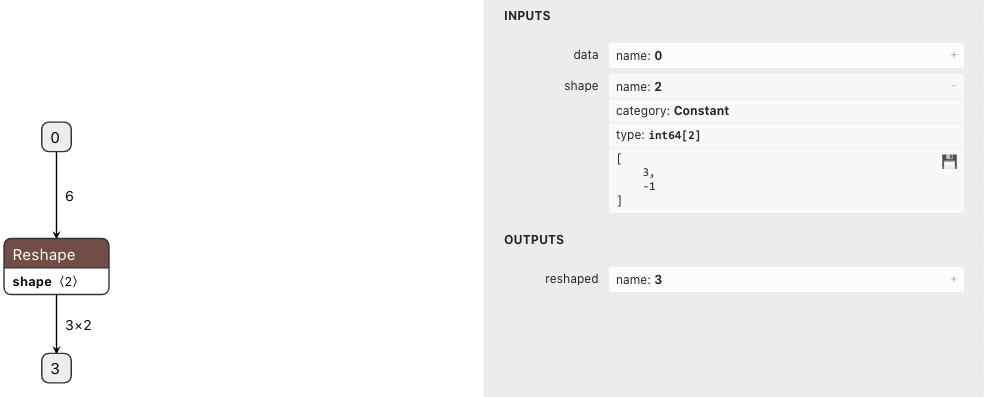

导出的onnx只有一个输入，Reshape中固定为3维

In [14]:
ort_session_const = ort.InferenceSession("const_op.onnx")
ort_session_const.run(None, {"input0": a.numpy()})

[array([[0, 1],
        [2, 3],
        [4, 5]], dtype=int64)]

In [15]:
class VarModel(nn.Module):    
    def forward(self, x, y):
        return x.reshape(y, -1)
    
var_model = VarModel()
var_model(a, b), var_model(a, c)

(tensor([[0, 1],
         [2, 3],
         [4, 5]]),
 tensor([[0, 1, 2],
         [3, 4, 5]]))

In [16]:
torch.onnx.export(var_model, (a, b), "var_op.onnx", input_names=["input0", "input1"])

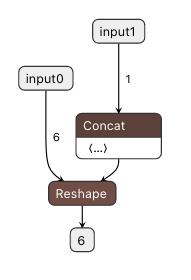

In [9]:
ort_session = ort.InferenceSession("var_op.onnx")
out1 = ort_session.run(None, {"input0": a.numpy(), "input1": b.numpy()})
out2 = ort_session.run(None, {"input0": a.numpy(), "input1": c.numpy()})
out1, out2

([array([[0, 1],
         [2, 3],
         [4, 5]], dtype=int64)],
 [array([[0, 1, 2],
         [3, 4, 5]], dtype=int64)])

## 返回类型不支持dict和string

In [11]:
class ReturnModel(nn.Module):
    def forward(self, x):
        return {"x": x, "y": "test"}

input_x = torch.ones(2, 2)
model = ReturnModel()
model(input_x)

{'x': tensor([[1., 1.],
         [1., 1.]]),
 'y': 'test'}

In [13]:
torch.onnx.export(model, input_x, "return.onnx", input_names=["intput"])

In [15]:
ort_session = ort.InferenceSession("return.onnx")
ort_session.run(None, {"intput": input_x.numpy()})

[array([[1., 1.],
        [1., 1.]], dtype=float32)]

输出结果中将字典转换为了list，并且没有返回string变量

## 参考

+ https://zhuanlan.zhihu.com/p/498425043
+ https://pytorch.org/docs/master/onnx.html